In [1]:
import sys
sys.path.insert(0, '../')
%load_ext autoreload

In [2]:
import numpy as np
import torch
import imageio
from glob import glob
from sklearn.preprocessing import StandardScaler

device = 'cuda'

# covers of the top 100 movies on www.imdb.com/chart/top the 13th of August 2019
# images downloaded from www.themoviedb.org
data = []
all_covers = glob('movie_covers/*.jpg')
for cover_jpg in all_covers:
    cover = imageio.imread(cover_jpg)
    data.append(cover.reshape(np.prod(cover.shape)))
    
original_shape = imageio.imread(all_covers[0]).shape

scaler = StandardScaler()
data = torch.tensor(scaler.fit_transform(data), dtype=torch.float32)

/tmp/ipykernel_18241/1327620524.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  cover = imageio.imread(cover_jpg)
/tmp/ipykernel_18241/1327620524.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_shape = imageio.imread(all_covers[0]).shape


In [3]:
from minisom_gpu.som import MiniSom

w = 10
h = 10
som = MiniSom(h, w, len(data[0]), learning_rate=0.5,
              sigma=3, neighborhood_function='triangle', random_seed=0)

som.train_random(data, 2500, verbose=True)
win_map = som.win_map(data)

 [ 2500 / 2500 ] 100% - 0:00:00 left 
 quantization error: tensor(102.9048)


In [4]:
som.activation_response(data)

tensor([[2., 2., 1., 2., 1., 1., 1., 0., 1., 1.],
        [2., 1., 1., 1., 3., 1., 0., 1., 1., 1.],
        [2., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [3., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 1., 2., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
        [2., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [2., 1., 2., 1., 0., 1., 0., 1., 1., 1.]])

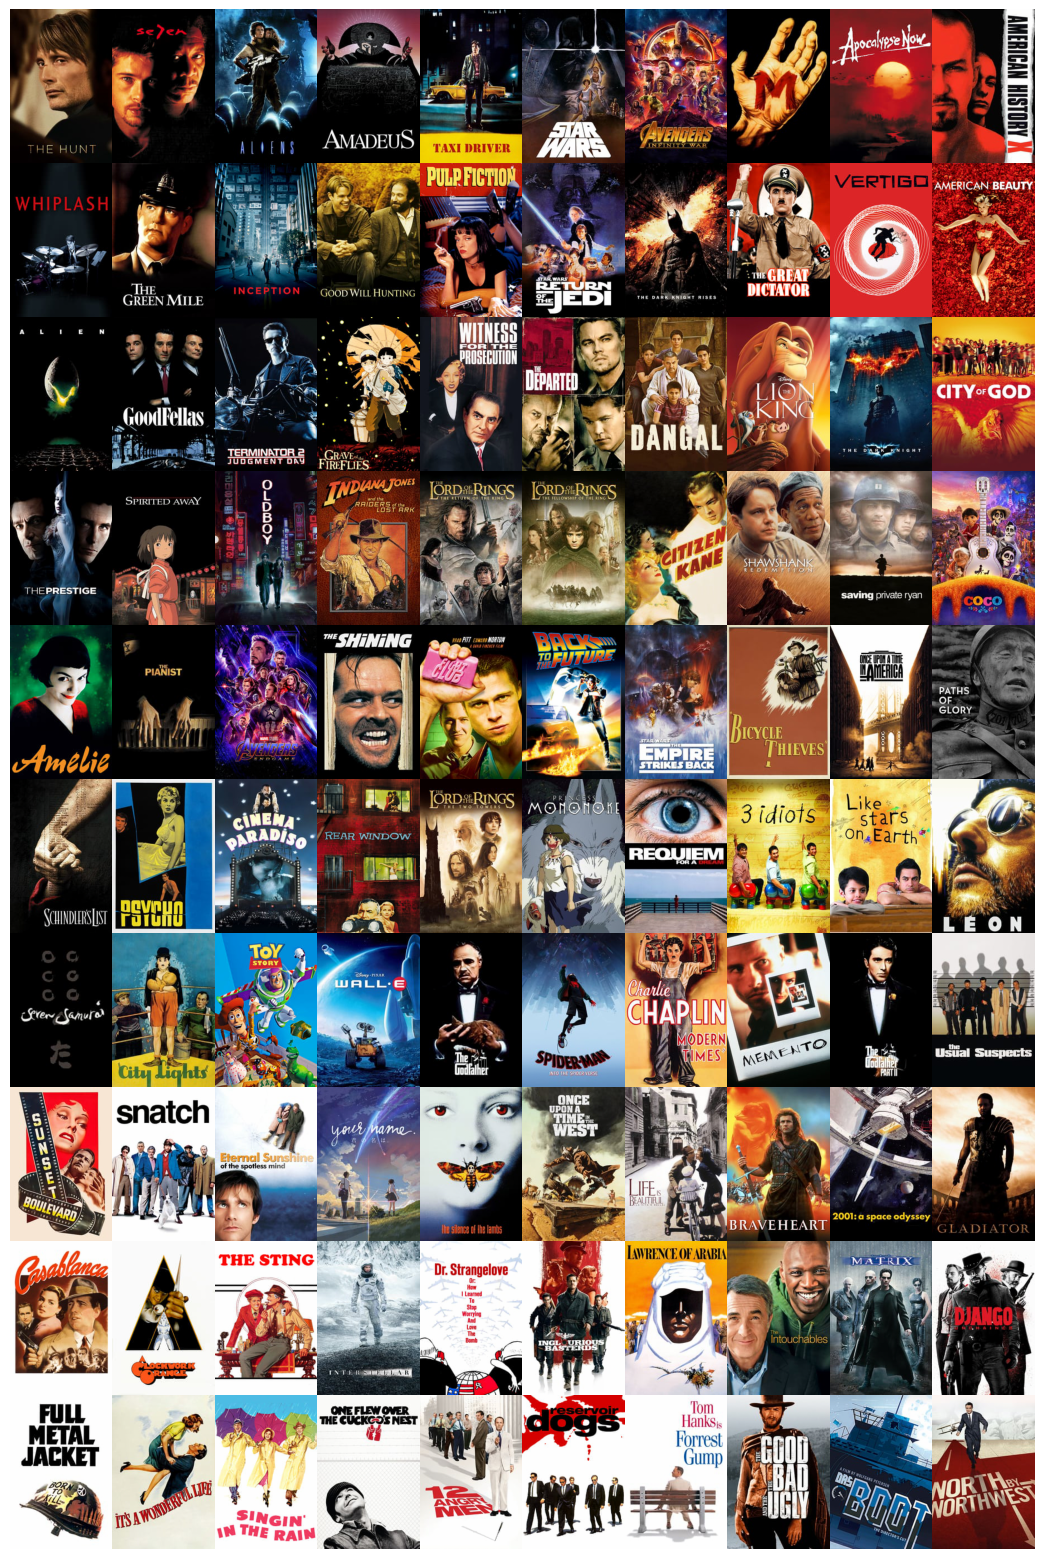

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

fig = plt.figure(figsize=(30, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(h, w), axes_pad=0)

def place_image(i, img):
    img = (scaler.inverse_transform(img.reshape(1, -1))).astype(int)
    grid[i].imshow(img.reshape(original_shape))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(w*h):
    position = np.unravel_index(i, (h, w))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (h, w))
    img = collided.pop()
    place_image(i, img)

plt.show()